In [26]:
# Installing Pillow Libraries
%pip install scikit-learn matplotlib Pillow

Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
np.set_printoptions(threshold=np.inf)
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [35]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [36]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [37]:
dirpath = 'SMAI-Dataset-release/IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


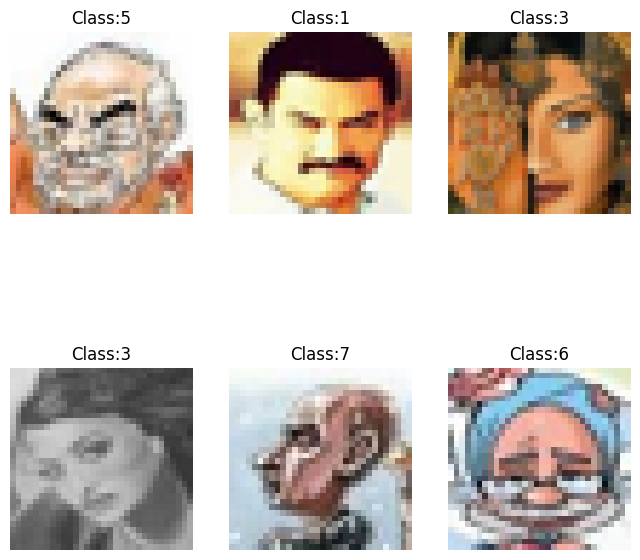

In [38]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No of components=200


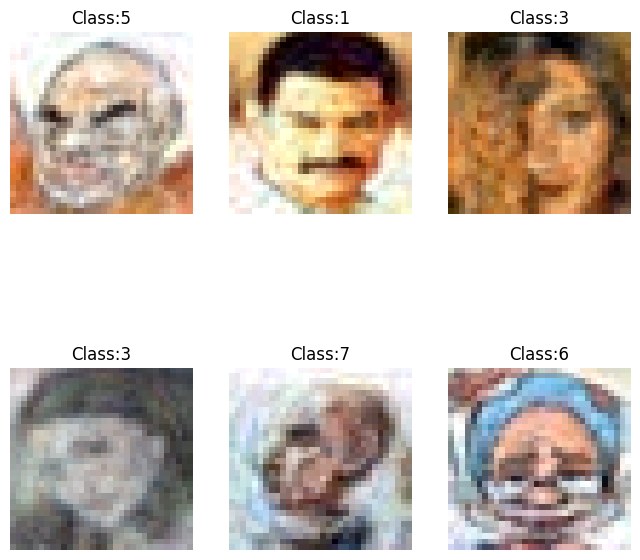

In [39]:
#--------------1.1------PCA Class+Dimensionality reduction on CFW Dataset--------------------

import numpy as np
import matplotlib.pyplot as plt

class MyPCA:
    def __init__(self):
        self.mean = None
        self.components = None
        self.eigenvalues=None

    def fit(self, X):
        if X.ndim > 2:
            X = X.reshape(X.shape[0], -1)
            
        self.mean = np.mean(X, axis=0)
    
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        self.eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        self.components = eigenvectors

    def transform(self, X, n_components):
        if X.ndim > 2:
            X = X.reshape(X.shape[0], -1)

        X_centered = X - self.mean
        projection_matrix = self.components[:, :n_components]
        reduced_data = X_centered.dot(projection_matrix)

        return reduced_data

if __name__ == "__main__":
    original_X=X
    a,b,c,d = original_X.shape
    X = X.reshape(X.shape[0], -1) 
    num_components_to_keep = [200]

    for n_components in num_components_to_keep:
        my_pca = MyPCA()
        my_pca.fit(X)
        reduced_X = my_pca.transform(X, n_components=n_components)
        reconstructed_X = reduced_X.dot(my_pca.components[:, :n_components].T) + my_pca.mean
        reconstructed_X = reconstructed_X.reshape((a,b,c,d))

        print(f"No of components={n_components}")
        display_images(reconstructed_X[ind,...],y[ind], row=2,col=3)


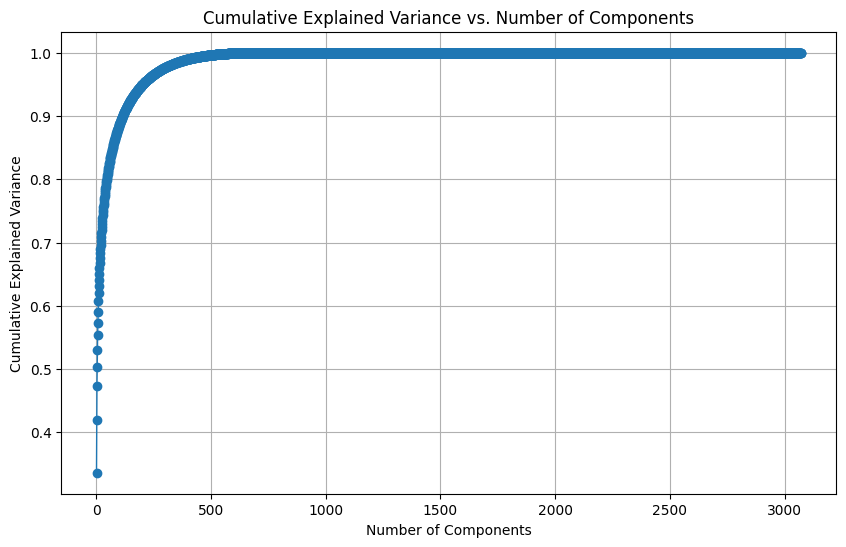

In [40]:
#-------------1.1---Cumulative explained variance vs Number of Components-------------------
cumulative_variance = np.cumsum(my_pca.eigenvalues) / np.sum(my_pca.eigenvalues)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-',linewidth=1)
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [41]:
#-------------1.1---Dimensionality reduction + Metrics-------------------
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

def split_data(data,encoder_type):

    if encoder_type == 'ResNet':
        encoded_data = data[:,1]
    elif encoder_type == 'VIT':
        encoded_data = data[:,2]
    else:
        encoded_data=None
        
    label_data=data[:,3]
    return encoded_data,label_data

data = np.load('data.npy',allow_pickle=True)
encoder_type='VIT'
X,Y=split_data(data,encoder_type)
X = np.concatenate(X, axis=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
num_components_to_keep = 100

my_pca = MyPCA()
my_pca.fit(X_train)
X_train_pca = my_pca.transform(X_train, n_components=num_components_to_keep)
X_test_pca = my_pca.transform(X_test, n_components=num_components_to_keep)

scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

knn_classifier_without_pca = KNeighborsClassifier(n_neighbors=5)
knn_classifier_without_pca.fit(X_train, Y_train)
knn_classifier_with_pca = KNeighborsClassifier(n_neighbors=5)
knn_classifier_with_pca.fit(X_train_pca, Y_train)

Y_pred_without_pca = knn_classifier_without_pca.predict(X_test)
Y_pred_with_pca = knn_classifier_with_pca.predict(X_test_pca)

accuracy_without_pca = accuracy_score(Y_test, Y_pred_without_pca)
precision_without_pca = precision_score(Y_test, Y_pred_without_pca, average='macro',zero_division=1.0)
recall_without_pca = recall_score(Y_test, Y_pred_without_pca,average='macro',zero_division=1.0)
f1_micro_without_pca = f1_score(Y_test, Y_pred_without_pca, average='micro')
f1_macro_without_pca = f1_score(Y_test, Y_pred_without_pca, average='macro')
accuracy_with_pca = accuracy_score(Y_test, Y_pred_with_pca)
precision_with_pca = precision_score(Y_test, Y_pred_with_pca, average='macro',zero_division=1.0)
recall_with_pca = recall_score(Y_test, Y_pred_with_pca,average='macro',zero_division=1.0)
f1_micro_with_pca = f1_score(Y_test, Y_pred_with_pca, average='micro')
f1_macro_with_pca = f1_score(Y_test, Y_pred_with_pca, average='macro')


print("KNN Classifier without PCA:")
print("Accuracy:", accuracy_without_pca)
print("Precision:", precision_without_pca)
print("Recall:", recall_without_pca)
print("F1 (Micro):", f1_micro_without_pca)
print("F1 (Macro):", f1_macro_without_pca)
print("\n")

print("KNN Classifier with PCA:")
print("Accuracy:", accuracy_with_pca)
print("Precision:", precision_with_pca)
print("Recall:", recall_with_pca)
print("F1 (Micro):", f1_micro_with_pca)
print("F1 (Macro):", f1_macro_with_pca)



KNN Classifier without PCA:
Accuracy: 0.21333333333333335
Precision: 0.5059085564139589
Recall: 0.2721381267738884
F1 (Micro): 0.21333333333333337
F1 (Macro): 0.12506201650143994


KNN Classifier with PCA:
Accuracy: 0.22666666666666666
Precision: 0.5243747422555369
Recall: 0.2854462314727216
F1 (Micro): 0.22666666666666666
F1 (Macro): 0.13674650743315783


Accuracy,precision,recall and other metrics of classifier increase after performing dimensionality reduction.

This may be due to following reasons:

Overfitting Reduction: High-dimensional data is more prone to overfitting, where a model learns to fit the noise in the data rather than the underlying patterns. By reducing the dimensionality of the data, we reduce the complexity of the model and make it less prone to overfitting, which can lead to improved accuracy and generalization.

Improved Feature Representation: Dimensionality reduction methods aim to preserve the most important information in the data while reducing its dimensionality. This often results in a more compact and informative representation of the data, which can lead to better discrimination between classes, thus improving precision and recall.

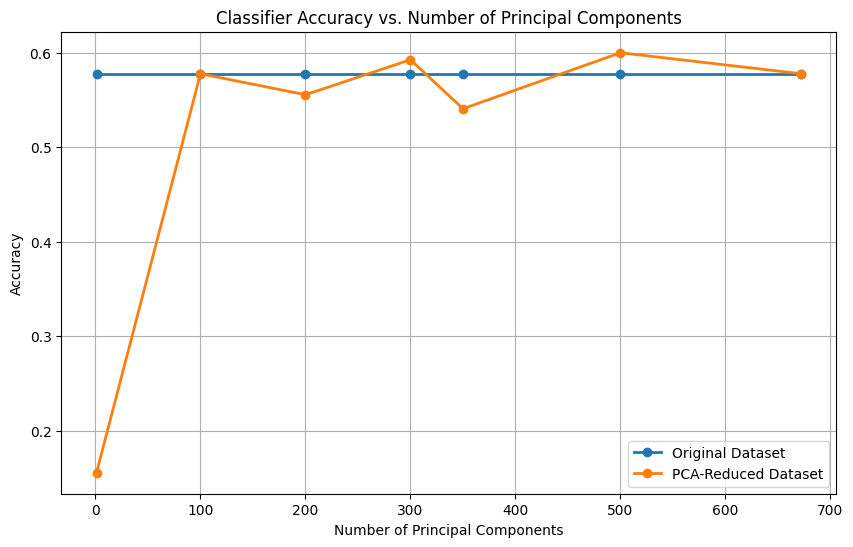

In [48]:
#-----1.1---Dimensionality reduction + Accuracy of Classifier after dimensionality reduction-------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

original_X = original_X.reshape(original_X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(original_X, y, test_size=0.2,random_state=42)
# n_components_range = range(1, original_X.shape[1] + 1)
n_components_range = [1,100,200,300,350,500,672]
accuracies_original = []
accuracies_pca = []
my_pca = MyPCA()
my_pca.fit(original_X)

for n_components in n_components_range:
    clf_original = RandomForestClassifier(random_state=42)
    clf_original.fit(X_train, y_train)
    y_pred_original = clf_original.predict(X_test)
    accuracy_original = accuracy_score(y_test, y_pred_original)
    accuracies_original.append(accuracy_original)
    reduced_X = my_pca.transform(original_X, n_components=n_components)
    reconstructed_X = reduced_X.dot(my_pca.components[:, :n_components].T) + my_pca.mean
    reconstructed_X = reconstructed_X.reshape(original_X.shape)
    X_train_pca, X_test_pca,y_train_pca, _ = train_test_split(reconstructed_X, y, test_size=0.2,random_state=42)
    clf_pca = RandomForestClassifier(random_state=42)
    clf_pca.fit(X_train_pca, y_train_pca)
    y_pred_pca = clf_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    accuracies_pca.append(accuracy_pca)

# Plot of accuracies vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, accuracies_original, label='Original Dataset', marker='o', linestyle='-', linewidth=2)
plt.plot(n_components_range, accuracies_pca, label='PCA-Reduced Dataset', marker='o', linestyle='-', linewidth=2)
plt.title('Classifier Accuracy vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



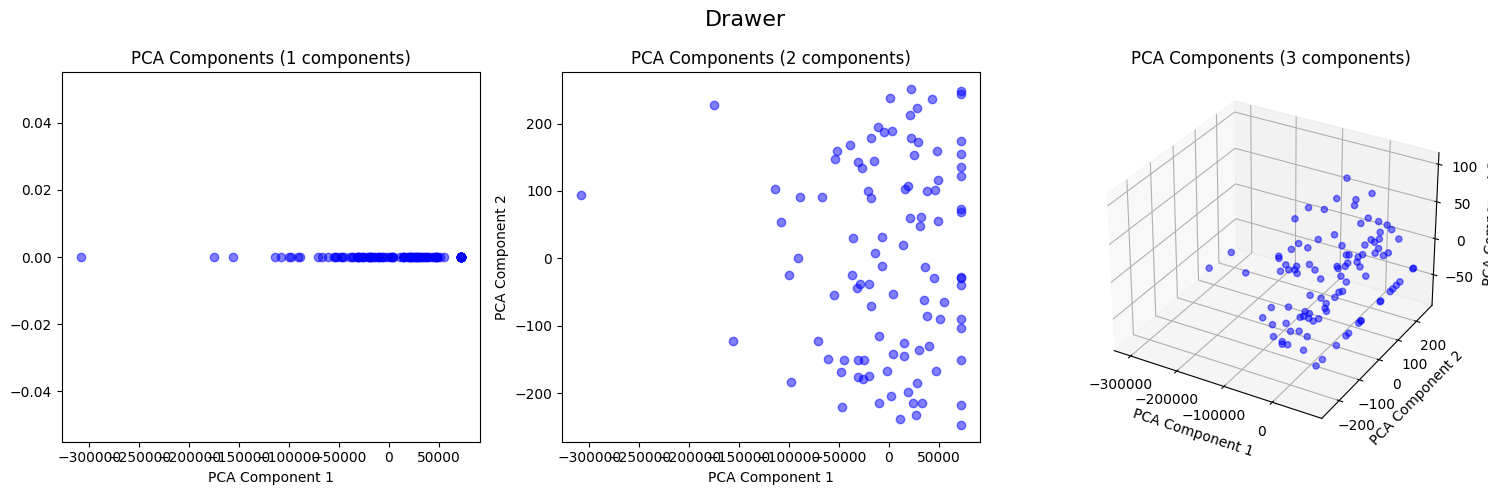

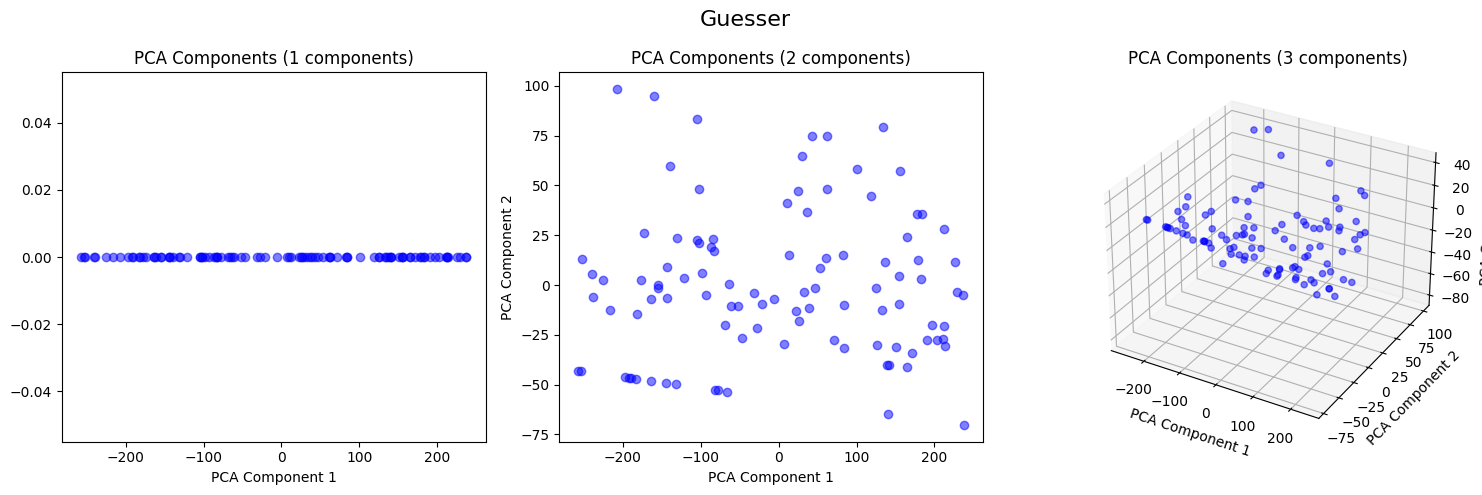

In [44]:
#-------------1.2---Dimensionality reduction on Pictionary Dataset-------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('drawer_attributes.csv') 
data=data.to_numpy()
n_components_range = [1, 2, 3]
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Drawer', fontsize=16)

for i, n_components in enumerate(n_components_range, 1):
    my_pca = MyPCA()
    my_pca.fit(data)
    reduced_X = my_pca.transform(data, n_components=n_components)
    if n_components == 3:
        ax = fig.add_subplot(1, len(n_components_range), i, projection='3d')
        ax.scatter(reduced_X[:, 0], reduced_X[:, 1], reduced_X[:, 2], c='b', marker='o', alpha=0.5)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')
        ax.set_title(f'PCA Components ({n_components} components)')
    elif n_components == 2:
        plt.subplot(1, len(n_components_range), i)
        plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c='b', marker='o', alpha=0.5)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title(f'PCA Components ({n_components} components)')
    else:
        plt.subplot(1, len(n_components_range), i)
        plt.scatter(reduced_X[:, 0], np.zeros_like(reduced_X[:, 0]), c='b', marker='o', alpha=0.5)
        plt.xlabel('PCA Component 1')
        plt.title(f'PCA Components ({n_components} components)')
plt.tight_layout()
plt.show()



data = pd.read_csv('guesser_attributes.csv') 
data=data.to_numpy()
n_components_range = [1, 2, 3]
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Guesser', fontsize=16)

for i, n_components in enumerate(n_components_range, 1):
    my_pca = MyPCA()
    my_pca.fit(data)
    reduced_X = my_pca.transform(data, n_components=n_components)
    if n_components == 3:
        ax = fig.add_subplot(1, len(n_components_range), i, projection='3d')
        ax.scatter(reduced_X[:, 0], reduced_X[:, 1], reduced_X[:, 2], c='b', marker='o', alpha=0.5)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')
        ax.set_title(f'PCA Components ({n_components} components)')
    elif n_components == 2:
        plt.subplot(1, len(n_components_range), i)
        plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c='b', marker='o', alpha=0.5)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title(f'PCA Components ({n_components} components)')
    else:
        plt.subplot(1, len(n_components_range), i)
        plt.scatter(reduced_X[:, 0], np.zeros_like(reduced_X[:, 0]), c='b', marker='o', alpha=0.5)
        plt.xlabel('PCA Component 1')
        plt.title(f'PCA Components ({n_components} components)')
plt.tight_layout()
plt.show()

The principal components obtained from PCA are a set of new axes that represent different sources of variability in the data. PC1 captures the most significant variation, and each subsequent component captures progressively less significant variation while remaining orthogonal to the previous ones. 